In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [2]:
original_data = pd.read_csv("C:\\Users\\sanch\\OneDrive\\Desktop\\PSTAT 197A\\Gold_prices.csv")

In [3]:
# Proceeding with cleaning the data
original_data['Date'] = pd.to_datetime(original_data['Date'], format='%m/%d/%Y')
gold_data = original_data[(original_data['Date'].dt.year >=2014) & (original_data['Date'].dt.year <= 2023)]


# clean numeric columns
for col in ['Open', 'High', 'Low', 'Close']:
    if gold_data[col].dtype != 'float64':  # If not already numeric
        gold_data.loc[:, col] = gold_data[col].str.replace(',', '').astype(float)

        
gold_data.head()

,Date,Open,High,Low,Close
1,2014-01-02,1204.5,1230.8,1202.5,1225.2
2,2015-01-02,1184.0,1194.9,1167.3,1186.2
3,2018-01-02,1305.3,1320.4,1304.6,1316.1
4,2019-01-02,1285.0,1291.0,1280.6,1284.1
5,2020-01-02,1521.0,1534.0,1519.7,1528.1


Exploratory Data Analysis (EDA)

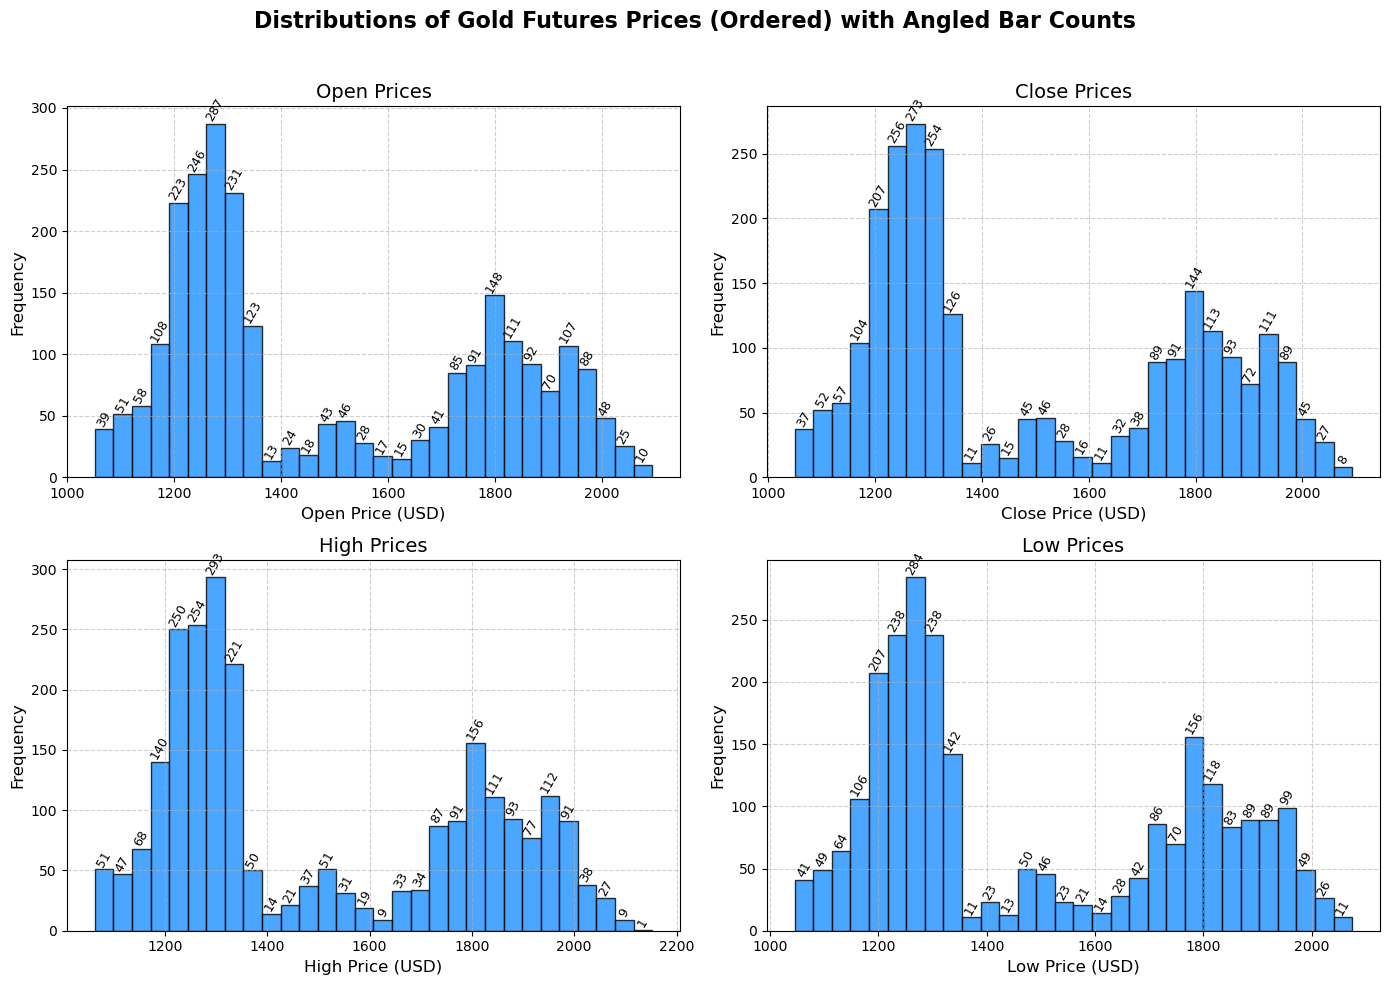

In [4]:
ordered_columns = ['Open', 'Close', 'High', 'Low']

# Plot the distribution of ordered numeric columns with angled count annotations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distributions of Gold Futures Prices (Ordered) with Angled Bar Counts', fontsize=16, fontweight='bold')

# List of ordered columns and their respective subplot locations
columns_and_axes = zip(ordered_columns, axes.flatten())

for col, ax in columns_and_axes:
    # Plot histogram
    counts, bins, patches = ax.hist(gold_data[col], bins=30, color='dodgerblue', edgecolor='black', alpha=0.8)
    
    # Annotate counts on top of each bar with angled text
    for count, bin_left, patch in zip(counts, bins, patches):
        if count > 0:  # Annotate only non-zero counts
            ax.text(
                bin_left + patch.get_width() / 2, 
                count, 
                f'{int(count)}', 
                ha='center', 
                va='bottom', 
                fontsize=9, 
                color='black', 
                rotation=60
            )
    
    ax.set_title(f'{col} Prices', fontsize=14)
    ax.set_xlabel(f'{col} Price (USD)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


The graph shows the distributions of gold futures prices, including **open**, **close**, **high**, and **low** prices, with frequencies displayed for each price range. The **open** and **close prices** show peaks between $1,200 and $1,400, with close prices slightly higher. The **high prices** have a broader spread, with more occurrences between $1,500 and $1,800, and the **low prices** are concentrated around $1,200. Overall, most price points fall within a narrower range, with fewer extremes in the dataset.

BASIC TIME SERIES ANALYSIS


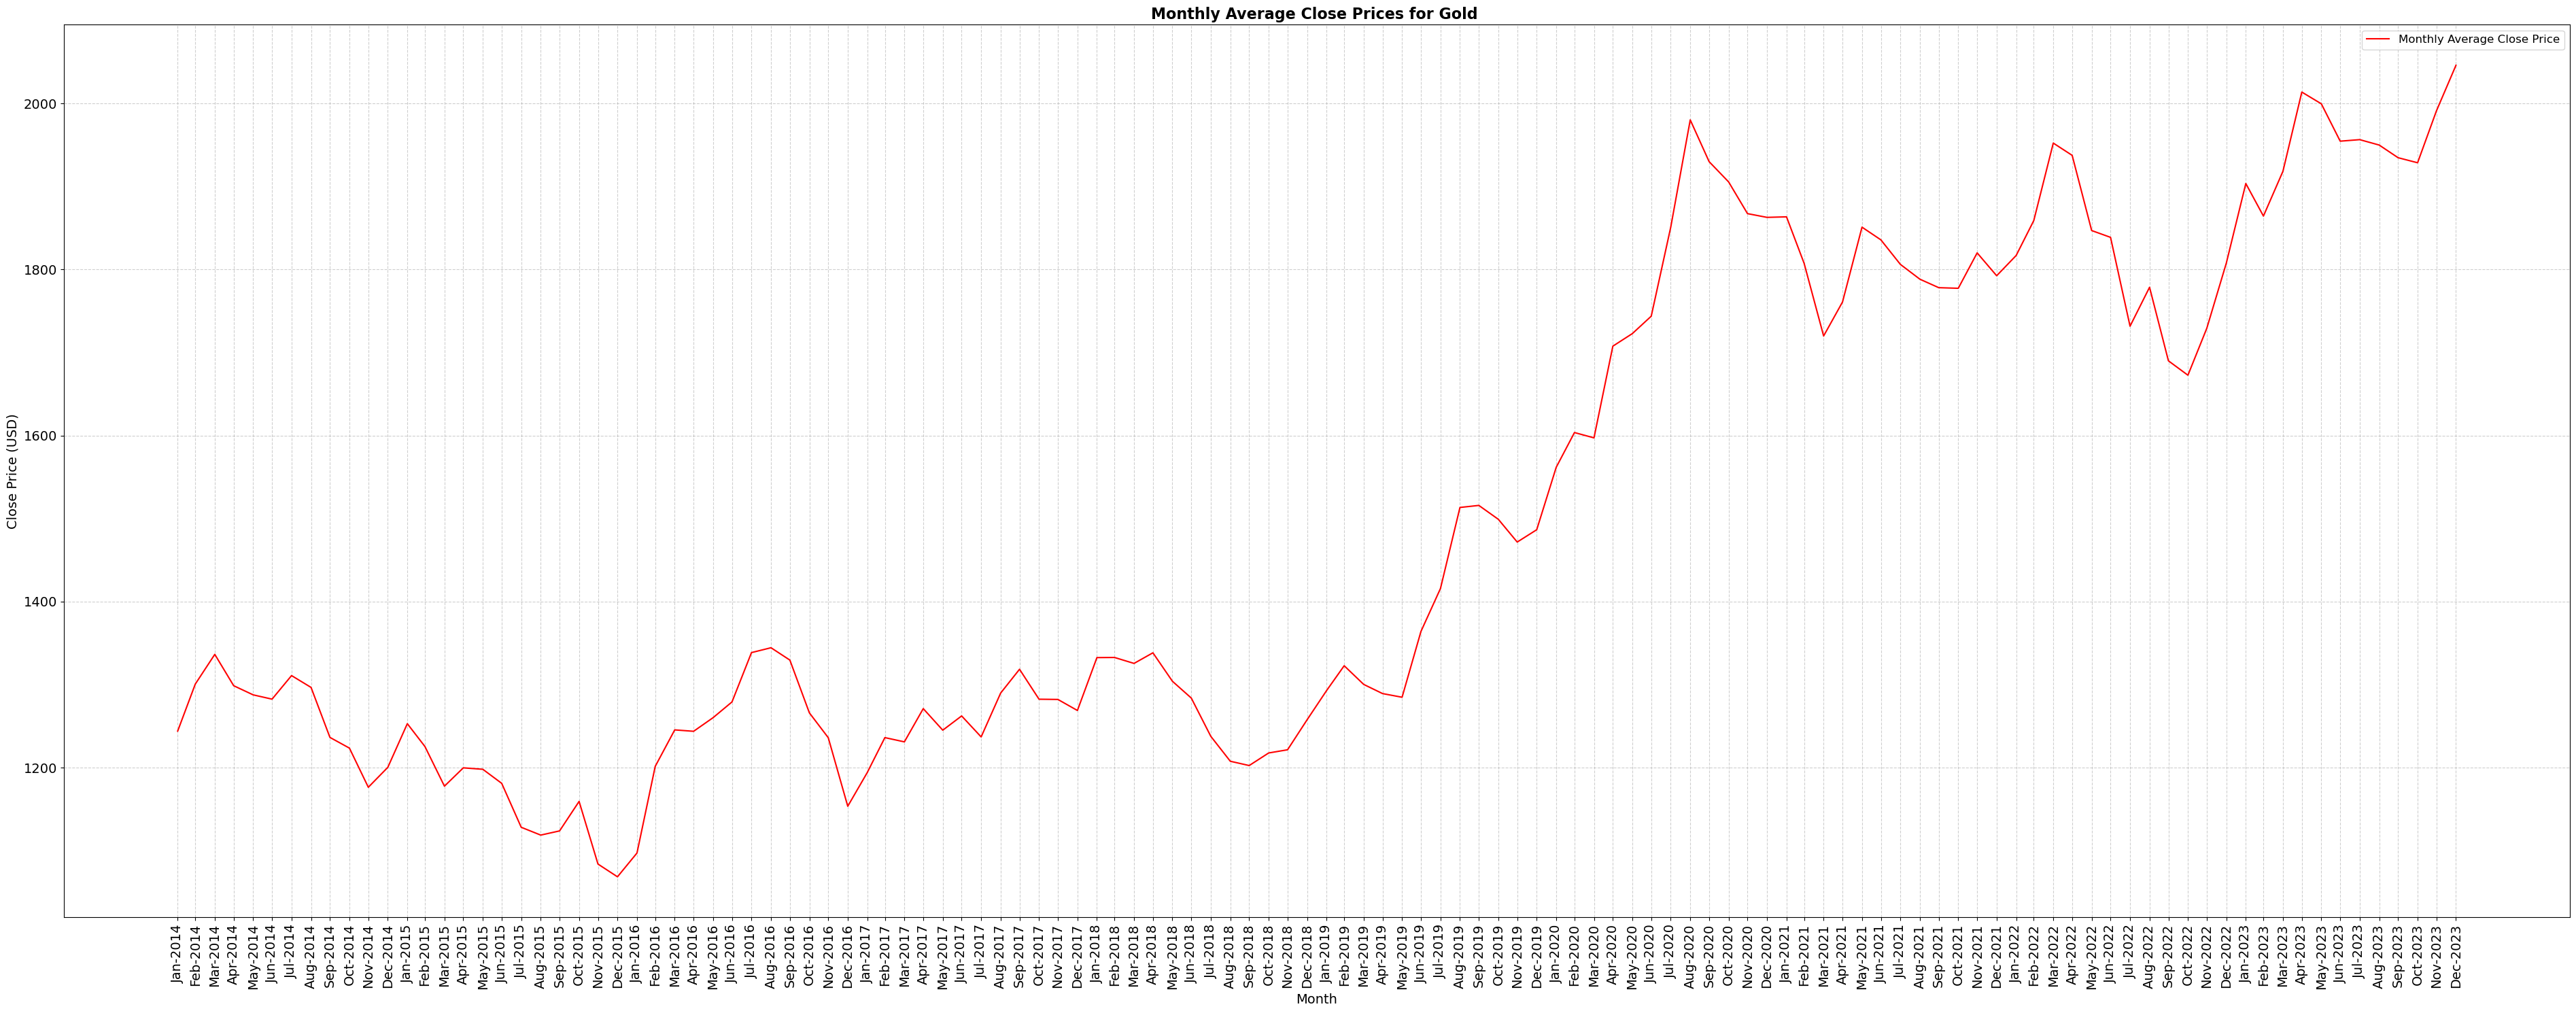

In [5]:
monthly_data = gold_data.resample('M', on='Date').mean()

# Plot close prices (monthly average)
plt.figure(figsize=(38, 15))
#plt.plot(monthly_data.index, monthly_data['Open'], label='Monthly Average Open Price', color='blue', linewidth=1.5)
plt.plot(monthly_data.index, monthly_data['Close'], label='Monthly Average Close Price', color='red', linewidth=1.5)
plt.title('Monthly Average Close Prices for Gold ', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The graph shows the **monthly average close prices for gold** from January 2014 to December 2023. The price starts relatively low around $1,200 in early 2014, with fluctuations seen over the years. From 2018 onwards, there is a clear upward trend, with prices consistently rising. The steep increase in late 2019 and into 2020 marks a period of significant price growth, reflecting a major market shift, possibly driven by global economic conditions. The graph peaks sharply in the later months of 2022 and 2023, indicating a surge in gold prices, highlighting a period of increased demand or market instability.

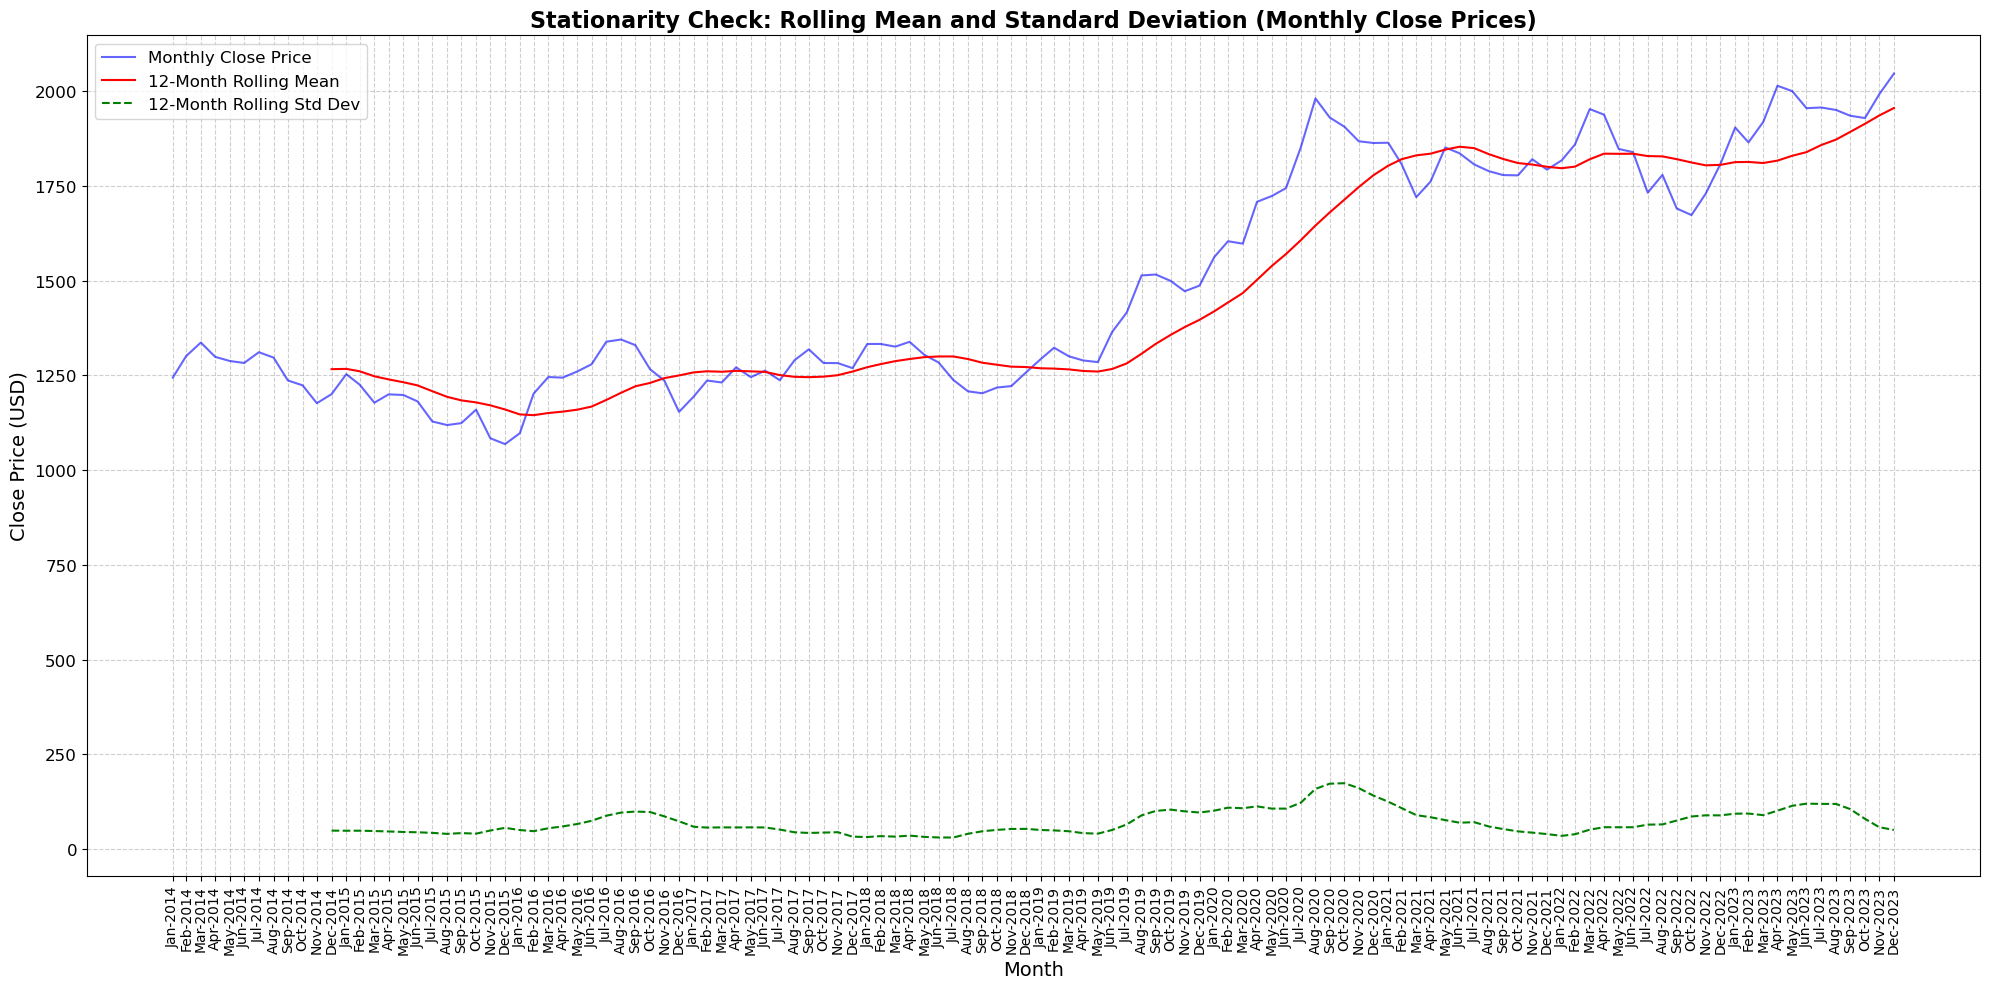

In [6]:
# Calculate rolling mean and standard deviation for monthly 'Close' prices
monthly_data['Rolling Mean'] = monthly_data['Close'].rolling(window=12).mean()  # 12 months rolling mean
monthly_data['Rolling Std'] = monthly_data['Close'].rolling(window=12).std()   # 12 months rolling standard deviation

# Plot the rolling mean and standard deviation to check stationarity
plt.figure(figsize=(20, 10))
plt.plot(monthly_data.index, monthly_data['Close'], color='blue', label='Monthly Close Price', alpha=0.6)
plt.plot(monthly_data.index, monthly_data['Rolling Mean'], color='red', label='12-Month Rolling Mean', linewidth=1.5)
plt.plot(monthly_data.index, monthly_data['Rolling Std'], color='green', label='12-Month Rolling Std Dev', linewidth=1.5, linestyle='--')
plt.title('Stationarity Check: Rolling Mean and Standard Deviation (Monthly Close Prices)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The graph shows a **stationarity check** for monthly close prices of gold, using the **rolling mean** and **rolling standard deviation**. The **blue line** represents the actual monthly close prices, which show an overall increasing trend over time, particularly after 2019. The **red line** shows the 12-month rolling mean, which follows a similar upward trajectory, confirming the trend in the gold prices. The **green dashed line** represents the 12-month rolling standard deviation, which remains relatively flat until around 2020, when it starts to rise, indicating increasing price volatility. This suggests that while the gold prices are trending upward, there are periods of increased fluctuation in recent years.

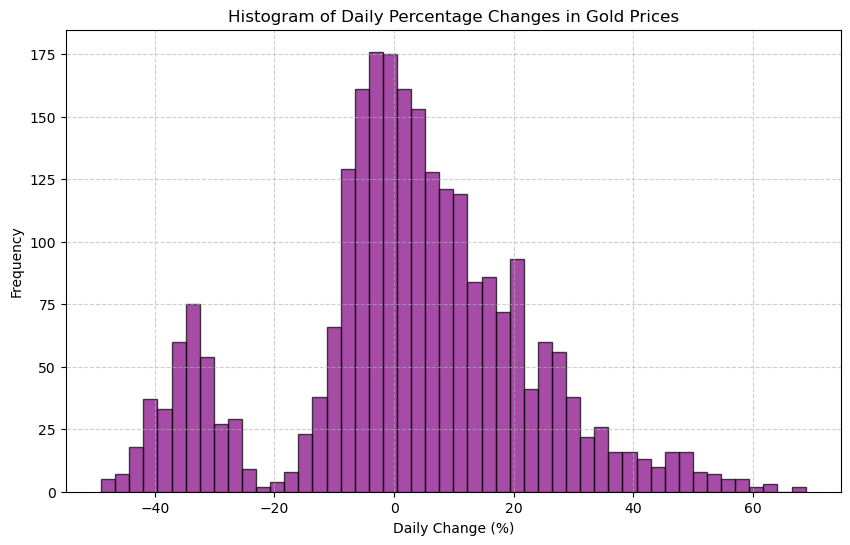

In [7]:
# votality analysis
gold_data['Daily Change (%)'] = gold_data['Close'].pct_change() * 100

# Plot the histogram of daily changes
plt.figure(figsize=(10, 6))
plt.hist(gold_data['Daily Change (%)'].dropna(), bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.title("Histogram of Daily Percentage Changes in Gold Prices")
plt.xlabel("Daily Change (%)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


The histogram displays the **daily percentage changes in gold prices**, showing the frequency of different percentage changes. The distribution is roughly **bell-shaped**, with the majority of daily changes falling within a range of -20% to +20%. The peak near 0% suggests that small daily changes are the most common, indicating a relatively stable market most of the time. However, there are **tails** extending toward both negative and positive extremes, representing occasional large daily price fluctuations, though these are less frequent. The spread of the data highlights the occasional sharp movements in gold prices, but overall, the daily changes are generally small.

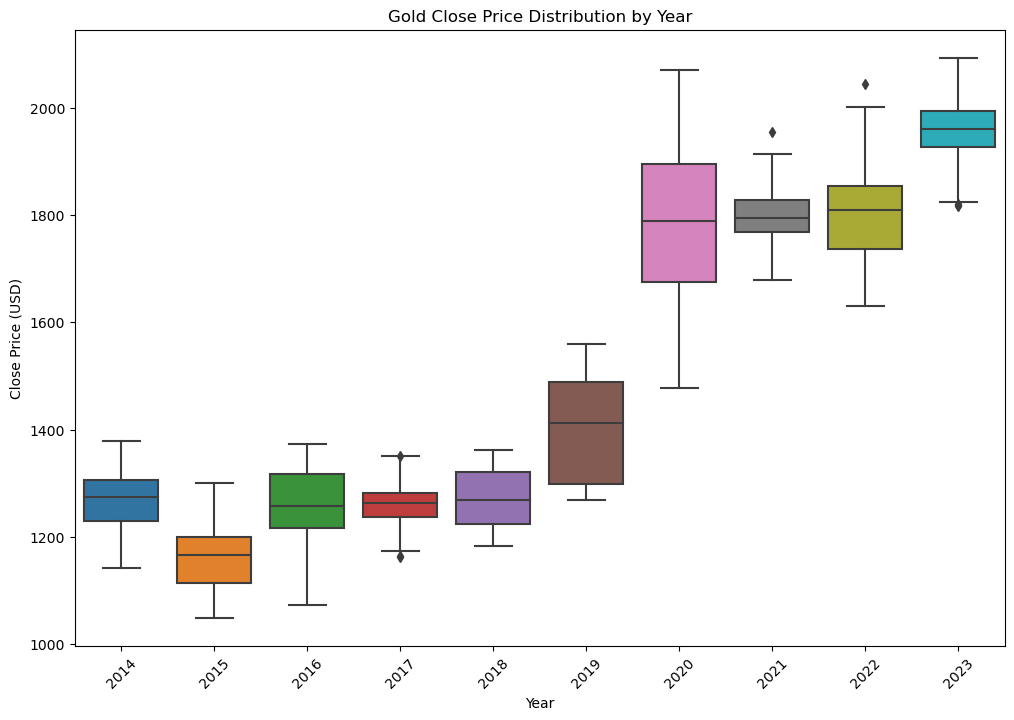

In [8]:
# trend over year
# extract year
gold_data['Year'] = gold_data['Date'].dt.year
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='Close', data=gold_data)
plt.title("Gold Close Price Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Close Price (USD)")
plt.xticks(rotation=45)
plt.show()


The boxplot shows the **distribution of gold close prices by year**, from 2014 to 2023. The plot reveals an overall **upward trend** in gold prices, with the **median close price** increasing over time. In **2014-2016**, the prices are concentrated in the lower $1,100-$1,300 range, while from **2017 onwards**, the median rises significantly, especially in **2020** and **2022**, reaching up to $1,800 and above. The **interquartile range** (the box) also widens in the later years, indicating increasing price volatility. **Outliers** appear in several years, particularly after 2020, suggesting occasional extreme price fluctuations. This highlights a period of significant market movements and the increasing value of gold.

In [9]:
# Drop Na/ Nan values
monthly_close_prices = monthly_data['Close'].dropna()

01:55:32 - cmdstanpy - INFO - Chain [1] start processing
01:55:33 - cmdstanpy - INFO - Chain [1] done processing


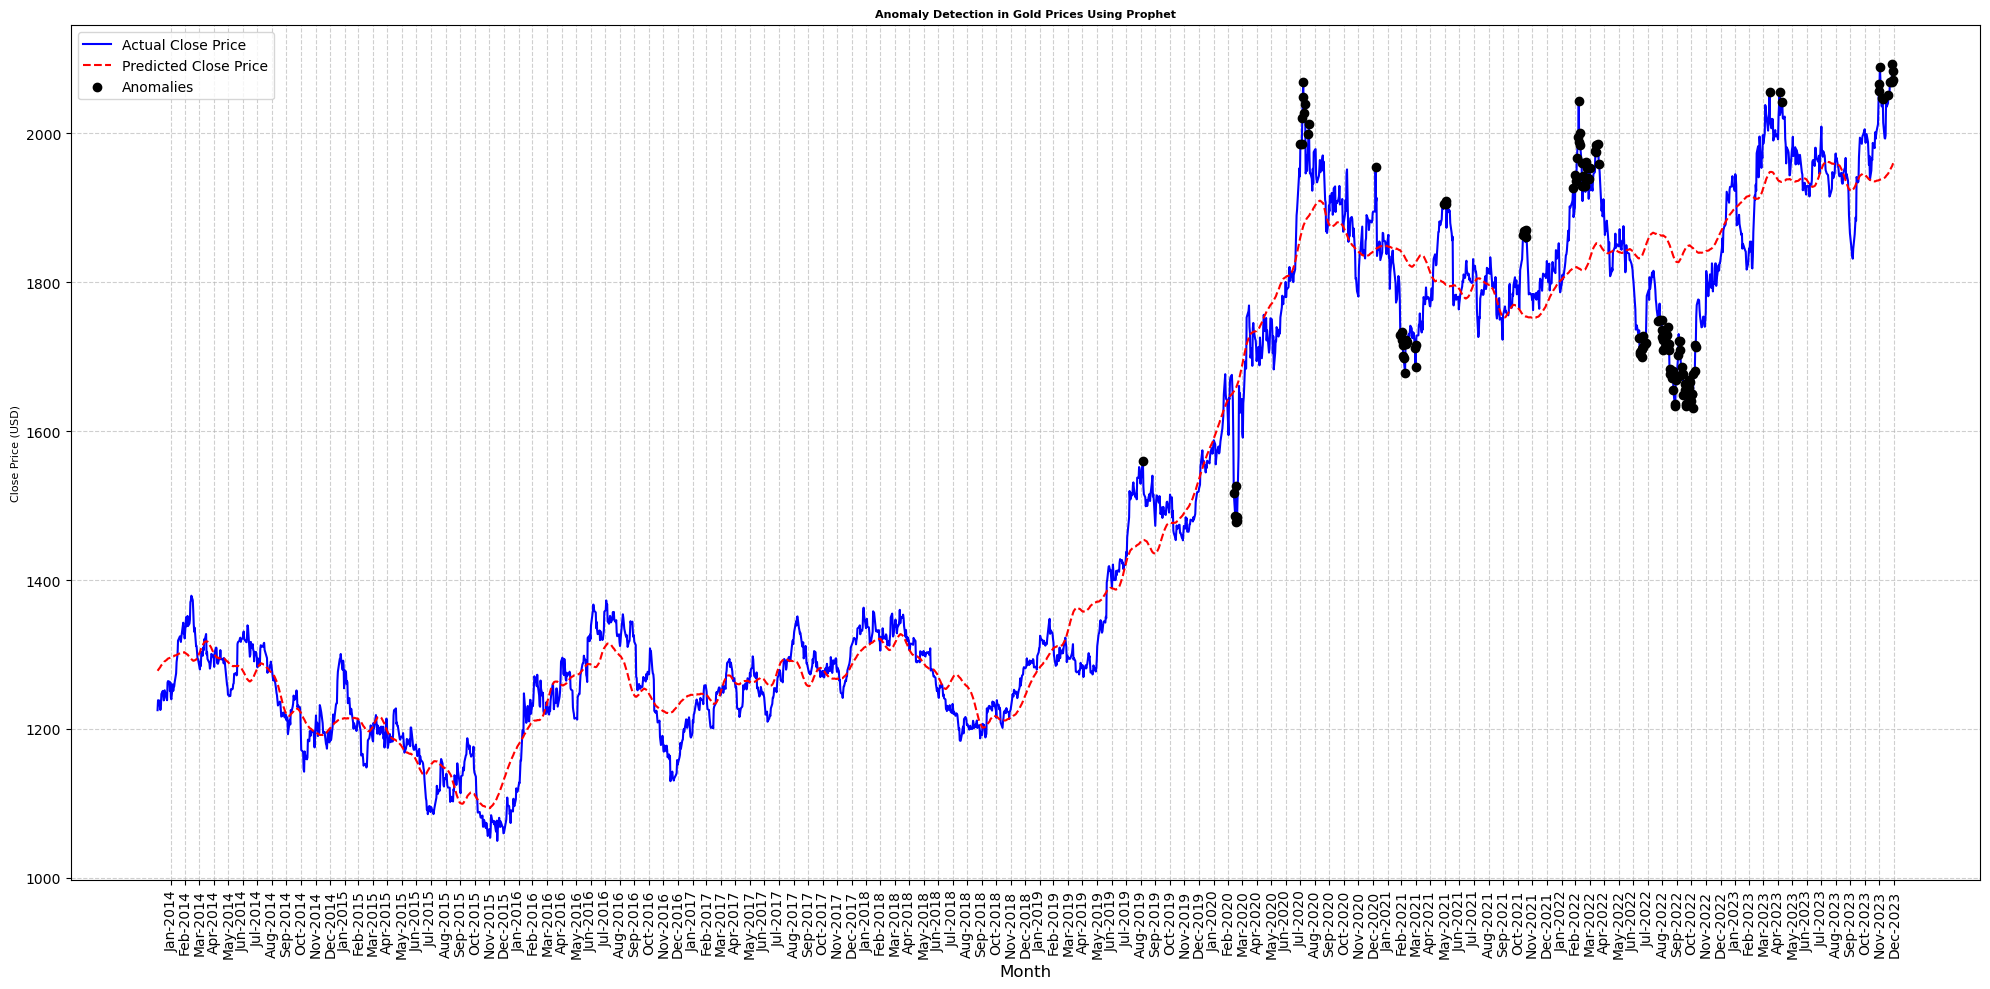

,ds,y,residual
1427,2019-09-04,1560.4,107.250235
1559,2020-03-13,1516.7,-136.660927
1560,2020-03-16,1486.5,-169.396878
1561,2020-03-17,1525.8,-131.288475
1562,2020-03-18,1477.9,-180.543721


In [10]:
# sort the data
gold_data = gold_data.sort_values(by='Date')
                                  
# Filter data for the years 2014 to 2023
filtered_gold_data = gold_data[(gold_data['Date'].dt.year >= 2014) & (gold_data['Date'].dt.year <= 2023)]

# Prepare the data for Prophet
prophet_data = filtered_gold_data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Drop missing values
prophet_data = prophet_data.dropna()

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Create a future dataframe with additional periods for prediction (IF NEEDED)
future = model.make_future_dataframe(periods= 0, freq = 'M')  
forecast = model.predict(future)

# Merge actual data into the forecast to calculate residuals
forecast = forecast.merge(prophet_data, on='ds', how='left')
forecast['residual'] = forecast['y'] - forecast['yhat']

# Define an adjustable threshold for anomalies (e.g., 2 standard deviations)

threshold = 2 * forecast['residual'].std()

# Flag anomalies based on the threshold
forecast['anomaly'] = np.abs(forecast['residual']) > threshold

# Plot the results
plt.figure(figsize=(20, 10))
plt.plot(forecast['ds'], forecast['y'], label='Actual Close Price', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Close Price', color='red', linestyle='--')
plt.scatter(
    forecast[forecast['anomaly'] == True]['ds'],
    forecast[forecast['anomaly'] == True]['y'],
    color='black',
    label='Anomalies',
    zorder=2
)

plt.title('Anomaly Detection in Gold Prices Using Prophet', fontsize=8, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=8)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.tight_layout()
plt.show()

# Display the anomalies
anomalies = forecast[forecast['anomaly'] == True][['ds', 'y', 'residual']]

anomalies.head(5)


The graph shows **anomaly detection in gold prices** using the **Prophet model**, with the **blue line** representing the actual close prices and the **red dashed line** showing the predicted close prices. The **black dots** indicate the detected anomalies, where the actual prices deviate significantly from the predicted values. Notably, anomalies appear throughout the timeline, particularly around **early 2020** and **late 2021**, with some extreme spikes and drops in price. These anomalies likely reflect market events or fluctuations that were not captured by the underlying trend, indicating times of significant market disruption or volatility.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Filter forecast for only the available actual data
forecast_with_actuals = forecast.dropna(subset=['y'])

# Calculate the metrics
mae = mean_absolute_error(forecast_with_actuals['y'], forecast_with_actuals['yhat'])
mape = np.mean(np.abs((forecast_with_actuals['y'] - forecast_with_actuals['yhat']) / forecast_with_actuals['y'])) * 100
rmse = np.sqrt(mean_squared_error(forecast_with_actuals['y'], forecast_with_actuals['yhat']))
r2 = r2_score(forecast_with_actuals['y'], forecast_with_actuals['yhat'])

# Print the metrics
print("Performance Metrics for Prophet Model:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Performance Metrics for Prophet Model:
Mean Absolute Error (MAE): 38.56
Mean Absolute Percentage Error (MAPE): 2.53%
Root Mean Square Error (RMSE): 52.59
R² Score: 0.97


The **MAE** of 38.56 indicates that, on average, the model’s predictions deviate from the actual gold prices by $38.56. The **MAPE** of 2.53% shows that the model is highly accurate, with predictions being only 2.53% off from the actual values on average. The **RMSE** of 52.59 suggests that the model performs well, with relatively few large errors. Finally, the **R² score** of 0.97 indicates that the model explains 97% of the variance in the gold prices, which means it captures most of the trends and patterns in the data. These metrics demonstrate that the Prophet model is effective for forecasting gold prices with high accuracy.


In [12]:
# Apply first-order differencing to the monthly 'Close' prices
monthly_data['Differenced Close'] = monthly_data['Close'].diff()

# Perform ADF test on differenced data
differenced_close_prices = monthly_data['Differenced Close'].dropna()
adf_test_diff = adfuller(differenced_close_prices)
adf_results_diff = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4],
    "Is Stationary": adf_test_diff[1] < 0.05
}

adf_results_diff

{'ADF Statistic': -8.822740832722781,
 'p-value': 1.8582910557904916e-14,
 'Critical Values': {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 'Is Stationary': True}

The results from the **Augmented Dickey-Fuller (ADF) test** indicate that the time series is **stationary**. The **ADF statistic** of -8.82 is significantly smaller than the critical values at the 1%, 5%, and 10% levels, which are -3.49, -2.89, and -2.58, respectively. The **p-value** of 1.86e-14 is extremely small, confirming that we can reject the null hypothesis of non-stationarity. This suggests that the series does not have a unit root and its statistical properties, such as mean and variance, do not change over time, making it suitable for time-series modeling.

In [13]:
# Exponential smoothing
alpha = 0.5  # Smoothing factor
monthly_data['Smoothed Close'] = monthly_data['Close'].ewm(alpha=alpha, adjust=False).mean()

# Perform ADF test on exponentially smoothed data
smoothed_close_prices = monthly_data['Smoothed Close'].dropna()
adf_test_smoothed = adfuller(smoothed_close_prices)
adf_results_smoothed = {
    "ADF Statistic": adf_test_smoothed[0],
    "p-value": adf_test_smoothed[1],
    "Critical Values": adf_test_smoothed[4],
    "Is Stationary": adf_test_smoothed[1] < 0.05
}

adf_results_smoothed

{'ADF Statistic': 0.016238333653114497,
 'p-value': 0.9598545595136266,
 'Critical Values': {'1%': -3.487517288664615,
  '5%': -2.8865777180380032,
  '10%': -2.5801239192052012},
 'Is Stationary': False}

The results from the **Augmented Dickey-Fuller (ADF) test** indicate that the time series is **non-stationary**. The **ADF statistic** of 0.0162 is much higher than the critical values at the 1%, 5%, and 10% levels, which are -3.49, -2.89, and -2.58, respectively. The **p-value** of 0.96 is very high, meaning we cannot reject the null hypothesis of non-stationarity. This suggests that the series has a unit root and its statistical properties, such as mean and variance, change over time, indicating that the data requires differencing or other transformations to make it stationary for time-series modeling.

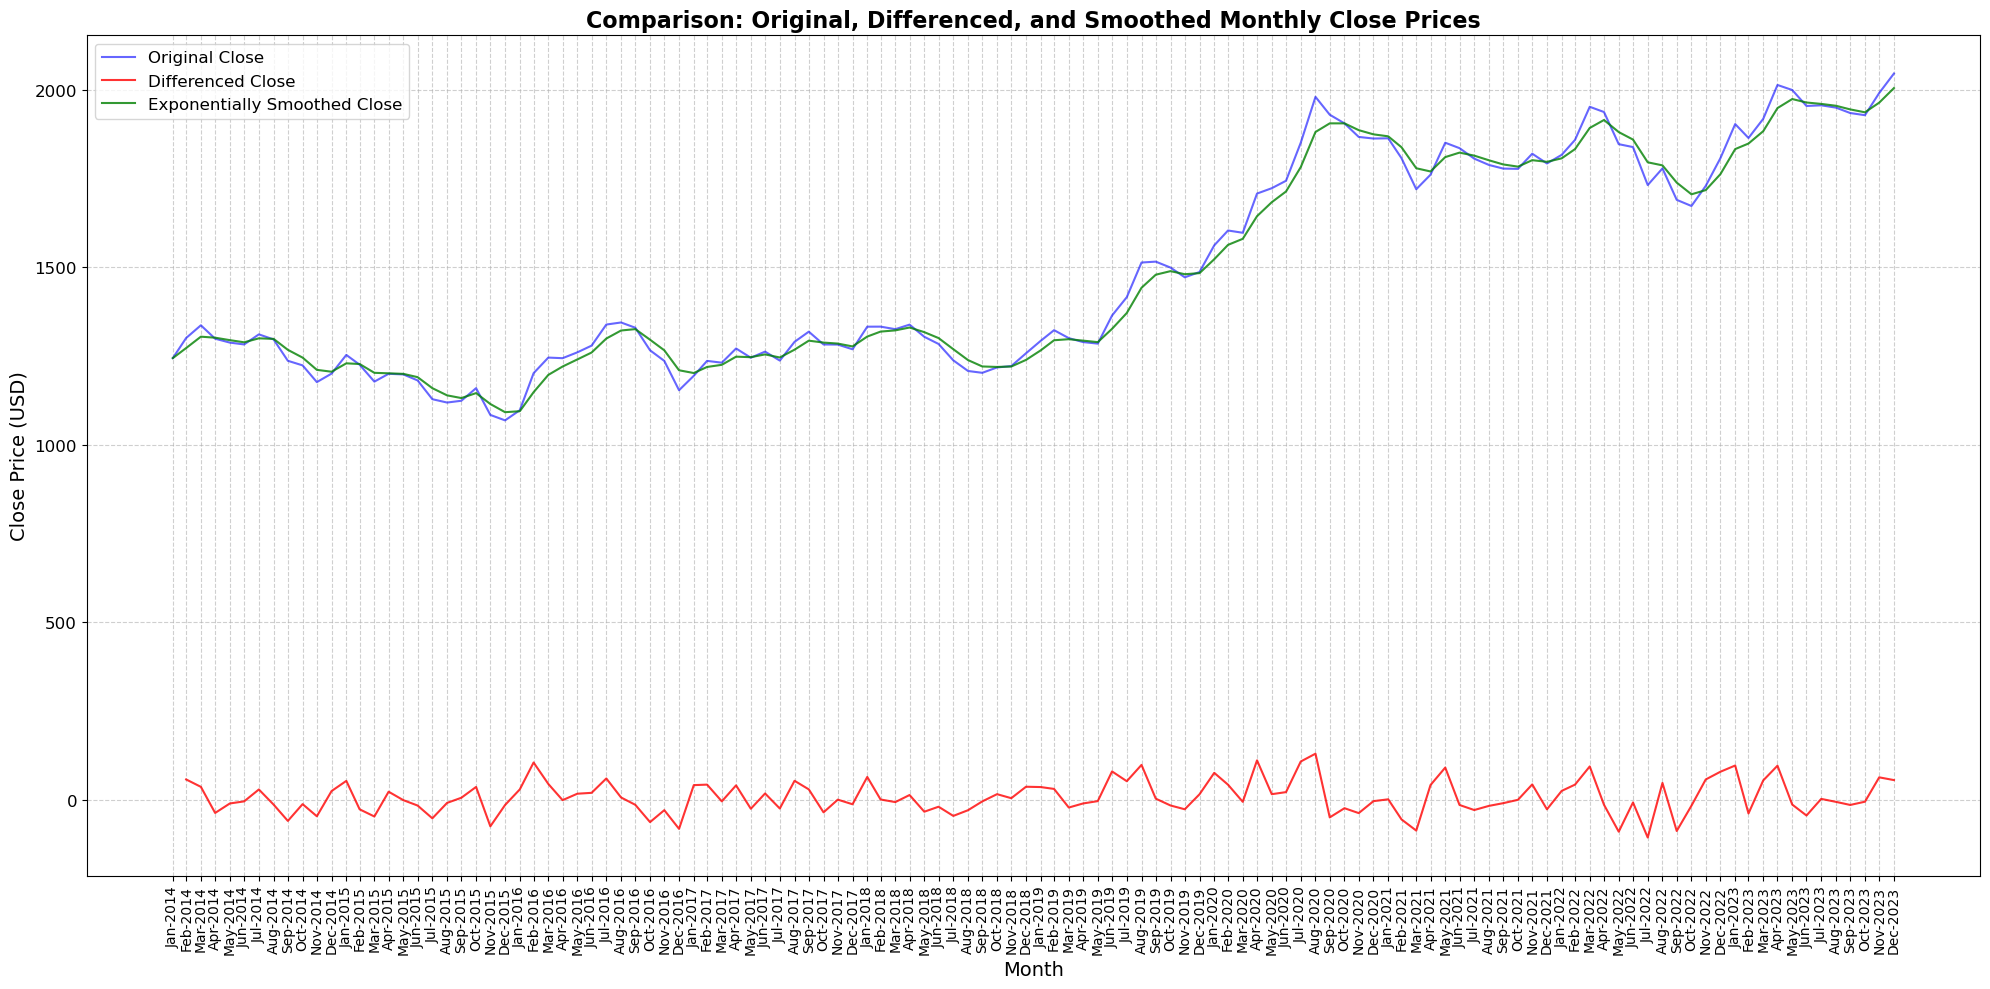

In [14]:
# Plot the original, differenced, and smoothed data
plt.figure(figsize=(20, 10))
plt.plot(monthly_data.index, monthly_data['Close'], label='Original Close', color='blue', alpha=0.6)
plt.plot(monthly_data.index, monthly_data['Differenced Close'], label='Differenced Close', color='red', alpha=0.8)
plt.plot(monthly_data.index, monthly_data['Smoothed Close'], label='Exponentially Smoothed Close', color='green', alpha=0.8)
plt.title('Comparison: Original, Differenced, and Smoothed Monthly Close Prices', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The graph compares the **original**, **differenced**, and **exponentially smoothed** monthly close prices of gold. The **blue line** represents the original close prices, showing the typical fluctuations in gold prices over time. The **green line** represents the exponentially smoothed close prices, which smooth out the fluctuations to highlight the underlying trend. The **red line** shows the differenced prices, emphasizing the changes between consecutive months. The differenced data reveals much more volatility, while the smoothed prices show a clearer, steady upward trend, especially in recent years, reflecting increasing gold prices. This comparison indicates how differencing removes trends and smoothing highlights the long-term movement.

In [15]:
# Use auto_arima to find the best ARIMA parameters
auto_arima_model = auto_arima(
    monthly_close_prices,
    start_p=0, max_p=5,  # Range for AR terms
    start_q=0, max_q=5,  # Range for MA terms
    d=1,                 # Differencing order (1 since we've already differenced)
    seasonal=False,      # No seasonality assumed
    trace=True,          # Display progress
    error_action='ignore',  # Ignore errors
    suppress_warnings=True, # Suppress warnings
    stepwise=True         # Use a stepwise search for efficiency
)

# Summary of the best model
best_model_params = auto_arima_model.get_params()
best_model_params


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1256.840, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1254.127, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1253.591, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1257.286, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1255.586, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1255.582, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1253.389, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1255.387, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1255.385, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1253.846, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1257.239, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.294 seconds


{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

The best model identified by auto_arima is ARIMA(0,1,1), indicating a first-order differencing and one moving average term.

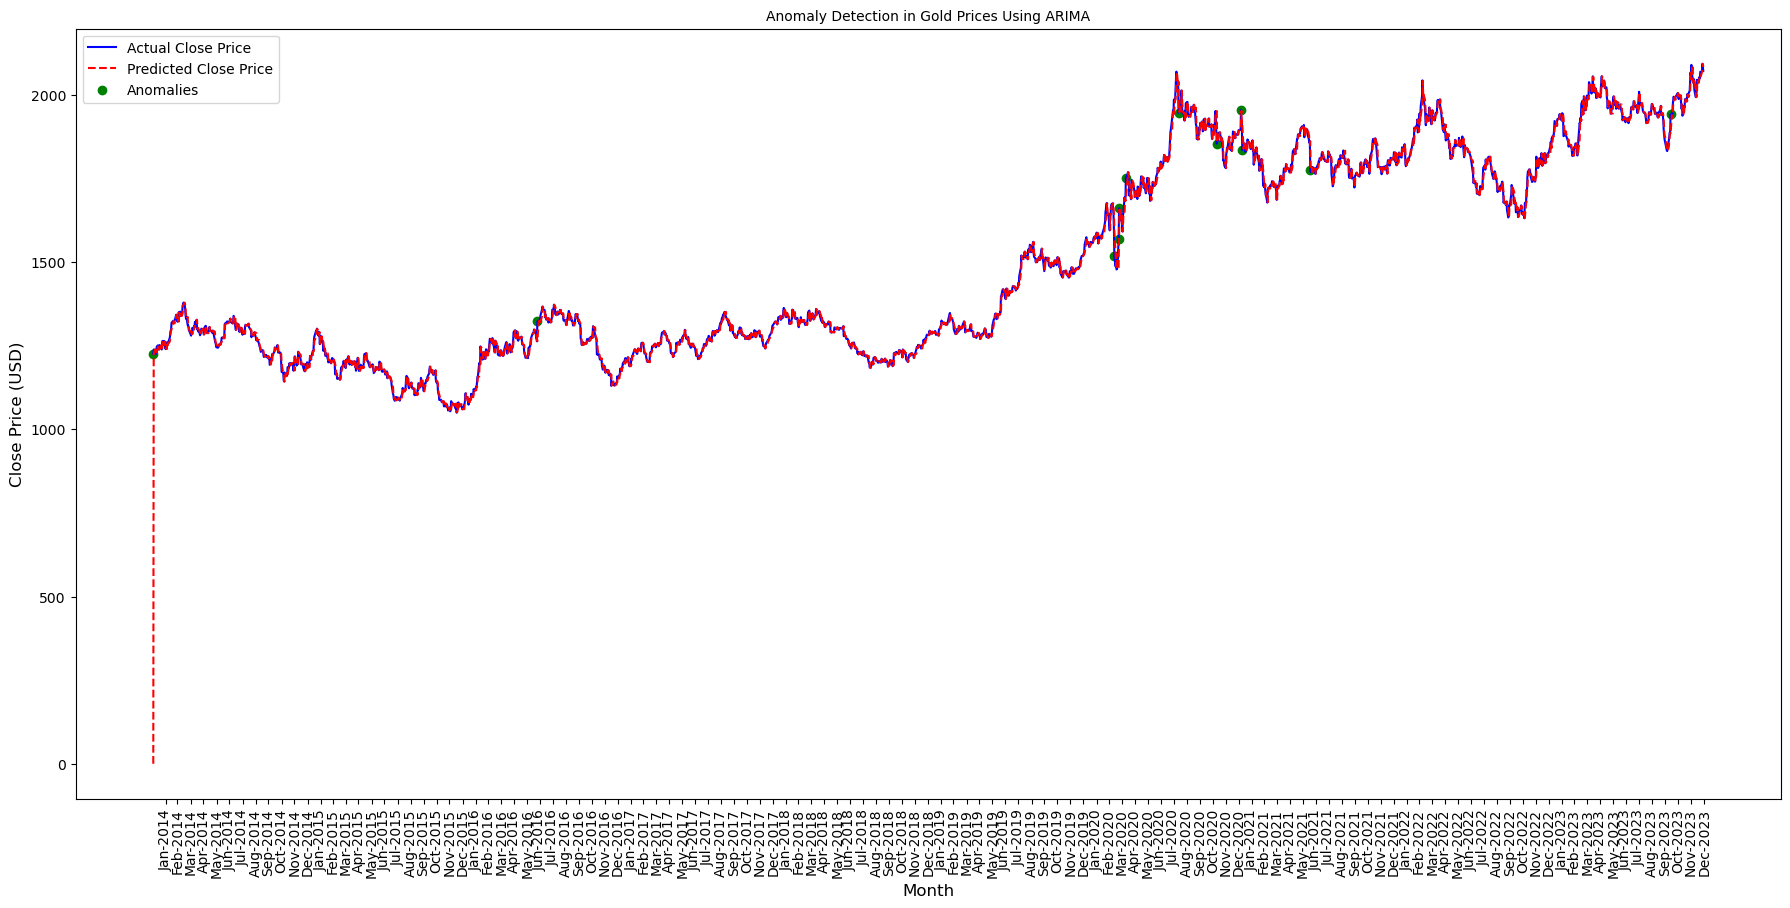

,Close Price (Anomalies)
Date,
2014-01-02,1225.200000
2016-06-24,59.042981
2020-03-13,-75.529282
2020-03-23,83.193695
2020-03-24,96.246792
2020-04-09,68.510678
2020-08-11,-93.025999
2020-11-09,-97.053346
2021-01-05,59.302800


In [19]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%d/%m/%Y')
filtered_gold_data = gold_data[(gold_data['Date'].dt.year >= 2014) & (gold_data['Date'].dt.year <= 2023)]
arima_data = filtered_gold_data[['Date', 'Close']].set_index('Date').dropna()

# Fit the ARIMA model (you may want to experiment with different p, d, q parameters)
model = ARIMA(arima_data['Close'], order=(0,1,1))  
model_fit = model.fit()

# Predict the values
predictions = model_fit.predict(start=0, end=len(arima_data)-1, typ='levels')

# Calculate residuals (actual - predicted)
residuals = arima_data['Close'] - predictions

# Define a threshold for anomalies (e.g., 2 standard deviations)
threshold = 2 * residuals.std()

# Flag anomalies based on the threshold
anomalies = residuals[abs(residuals) > threshold]

# Plot the results
plt.figure(figsize=(22, 10))
plt.plot(arima_data.index, arima_data['Close'], label='Actual Close Price', color='blue')
plt.plot(arima_data.index, predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.scatter(anomalies.index, arima_data.loc[anomalies.index, 'Close'], color='green', label='Anomalies')
plt.title('Anomaly Detection in Gold Prices Using ARIMA', fontsize=10)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.legend()
plt.show()

anomalies_df = pd.DataFrame({
    'Date': anomalies.index,
    'Close Price (Anomalies)': anomalies.values
}).set_index('Date')


anomalies_df



The graph displays **anomaly detection in gold prices using the ARIMA model**, with the **blue line** representing the actual close prices and the **red dashed line** showing the predicted values. The **green dots** highlight the anomalies, where the actual prices significantly deviate from the predicted trend. Notable anomalies are detected, especially around **January 2014**, where the price sharply drops, as well as several points throughout the timeline, particularly during periods of rapid price changes. These anomalies indicate unusual market behavior or potential outliers that were not captured by the ARIMA model's forecast.

In [17]:
# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(residuals) / arima_data['Close']) * 100

# Calculate R-squared (R²)
ss_total = np.sum((arima_data['Close'] - arima_data['Close'].mean())**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R² Score: {r_squared}')


Mean Absolute Error (MAE): 10.454115457376435
Root Mean Squared Error (RMSE): 28.388856611301442
Mean Absolute Percentage Error (MAPE): 0.6962973452725412%
R² Score: 0.9908198057630714


The **MAE of 10.45** indicates that, on average, the model's predictions are off by $10.45, which is a very small error considering the scale of the data. The **RMSE of 28.39** confirms that most of the errors are small, with fewer large deviations. The **MAPE of 0.70%** shows that the model is highly accurate, with predictions being less than 1% off from the actual values on average. Finally, the **R² score of 0.99** indicates that the ARIMA model explains 99% of the variance in the gold prices, which is an excellent result, demonstrating the model's strong ability to capture the overall trend and make accurate forecasts.

**GENERAL OVERVIEW AND CONCLUSIONS:**
Both the Prophet and ARIMA models are widely used for time-series forecasting, but they differ in their approaches to modeling and anomaly detection. After evaluating both models based on their predictive accuracy and anomaly detection capabilities, we can compare their performance metrics to understand their strengths and weaknesses.

The ARIMA model is particularly effective at detecting anomalies in the gold prices because it closely tracks short-term deviations from the expected trend. It's low MAE and RMSE values show that the model is very accurate in its predictions. However, ARIMA's strength lies in short-term forecasting and anomaly detection rather than capturing long-term trends. On the other hand, the Prophet model excels in handling long-term trends and seasonality. It works well when the goal is to forecast future gold prices over a longer time horizon and handle missing data.
